# Assignment

The goals for this assignment are to:
1) Give you a sense of the flavor of data and modeling we often do here.
2) Assess your ability to effectively wrangle and analyze data.
3) Assess your ability to design, train and evaluate neural networks 

**Guidelines**

- Fill out the notebook below: the easier it is for us to follow your code, plot, and notebook the better.

## Biological question

In this assignment, you will strive to build a representation that distinguishes the T cells (a core immune subset) in breast cancer versus normal breast tissues.

## Libraries

Here are some common libraries you'll probably want to use. [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html) is a common library for analyzing single-cell RNA-seq (and a [classic tutorial on 3K cells](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)). [AnnData](https://anndata.readthedocs.io/en/latest/) is a common data format. Feel free to use others as well.
For the AutoEncoder use pytorch.

In [1]:
import anndata as ad
import scanpy as sc

{p.__name__: p.__version__ for p in [ad, sc]}

{'anndata': '0.11.4', 'scanpy': '1.11.0'}

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import silhouette_score
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

torch.manual_seed(42)
np.random.seed(42)

## Dataset

The dataset you'll be examining is a subset of data from [Kumar et al. (2023) Nature](https://www.nature.com/articles/s41586-023-06252-9) ([PDF](./s41586-023-06252-9.pdf)), whose data is available via CZI's cellxgene portal ([publication data link](https://cellxgene.cziscience.com/collections/4195ab4c-20bd-4cd3-8b3d-65601277e731)).

You will work with the "scRNA-seq data - T cells" subset (76,567 cells). You can download it into AnnData's h5ad format (~425 MB) by clicking the "Download" button next to it and copy-pasting a link like the following (though you should replace the below link with a fresh one given to you by the website).

In [1]:
!curl -o dataset.h5ad "https://datasets.cellxgene.cziscience.com/a87890d9-bf31-4043-a3b7-1b46df89d8ff.h5ad"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  427M  100  427M    0     0   290M      0  0:00:01  0:00:01 --:--:--  290M


## Exploratory data analysis

Explore the data. You can use some of the common workflows in the [Scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) as well as anything else you'd like to see. Some common questions are:
- Should we filter down what genes to look at? If so, how should we do it?
- How much between-donor heterogeneity is there in the cell type abundance?
- Are there big differences in effect from samples from different `assay` types?

Some other things to keep in mind:
- The number of UMI counts (over all the genes) for each cell will varies and is not interesting in and of itself.
- The number of cells will be different for each `sample_id`, but this doesn't really mean anything.

In [3]:
# Load and preprocess data
print("Loading data...")
adata = ad.read_h5ad('./dataset.h5ad')

Loading data...


In [4]:
adata.shape

(76567, 33145)

We see that we have ~76.5K cells across ~33K genes. The (sparse) gene expression data is stored in the `X` variable:

In [5]:
adata.X.shape, adata.X.dtype, adata.X.__class__

((76567, 33145), dtype('float32'), scipy.sparse._csr.csr_matrix)

Some of the most interesting metadata are
- `cell_type`
- `sample_id`
- `donor_id`
- `assay`
- `disease` or 'reported_diseases' (notice that they were having data curation issues with the disease column in which every cell seemed normal
- `development_stage`

### General look at the data -- check clustering patterns in context of disease, cell_type and assays

In [6]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')

In [7]:
# UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/opt/conda/envs/multi-llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


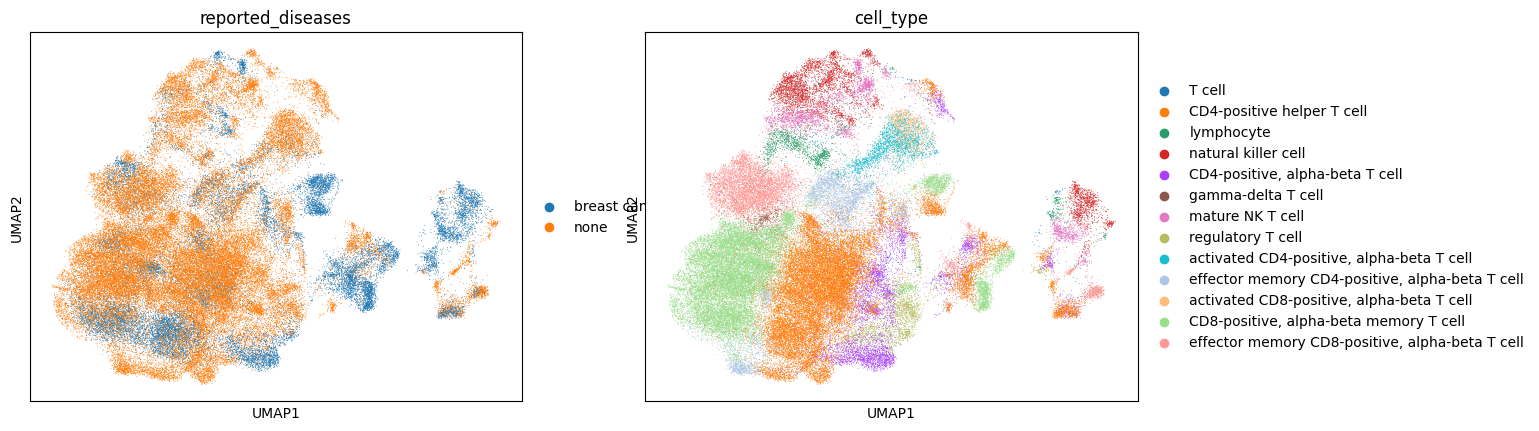

In [8]:
sc.pl.umap(adata, color=['reported_diseases', 'cell_type'])

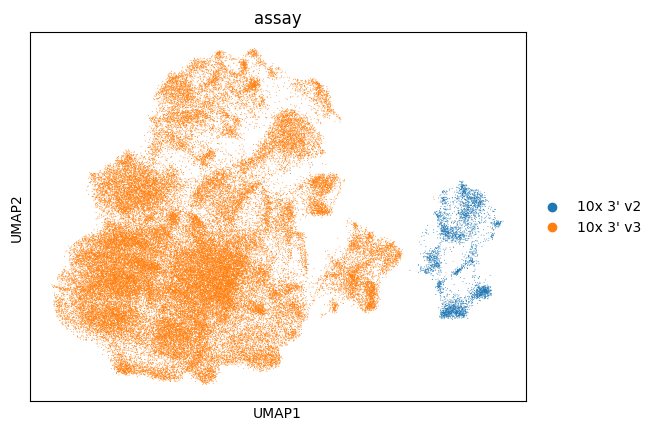

In [9]:
sc.pl.umap(adata, color=['assay'])

Conclusion on clusteing patterns -- there are clusters:
- disease vs normal (but smoothed for part of the data)
- cell types
- assays (technical batch effect)


### Between-donor heterogeneity in the cell type abundance

In [10]:
# Grouping by donor_id and cell_type to summarize cell counts
cell_type_abundance = adata.obs.groupby(['donor_id', 'cell_type']).size().unstack(fill_value=0)

/tmp/ipykernel_3070/2283111006.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_abundance = adata.obs.groupby(['donor_id', 'cell_type']).size().unstack(fill_value=0)


In [11]:
# Calculate variance in cell type abundance across donors
variance_abundance = cell_type_abundance.var(axis=0)

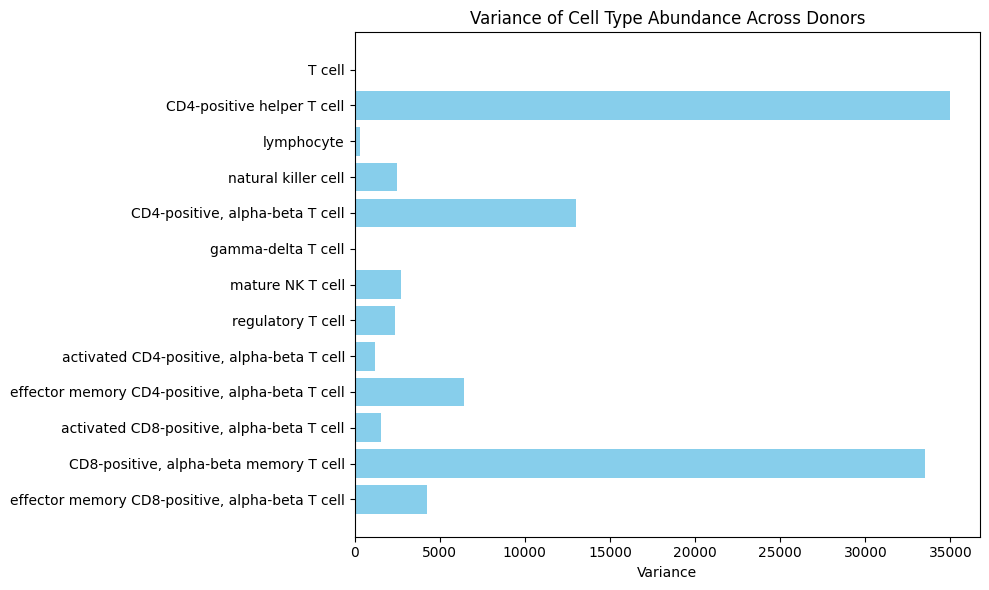

In [12]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(variance_abundance.index.values, variance_abundance.values, color='skyblue')
plt.xlabel('Variance')
plt.title('Variance of Cell Type Abundance Across Donors')
plt.gca().invert_yaxis() 
plt.tight_layout()

plt.show()

There are a couple of cell types with high variance between donors: CD4-positive helper T cell, CD8-positive, alpha-beta memory T cell. We can use cell type as additional information channel in AE loss

## Data Preprocessing

In [13]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [14]:
sc.pp.calculate_qc_metrics(
    adata, percent_top=None, log1p=False, inplace=True
)

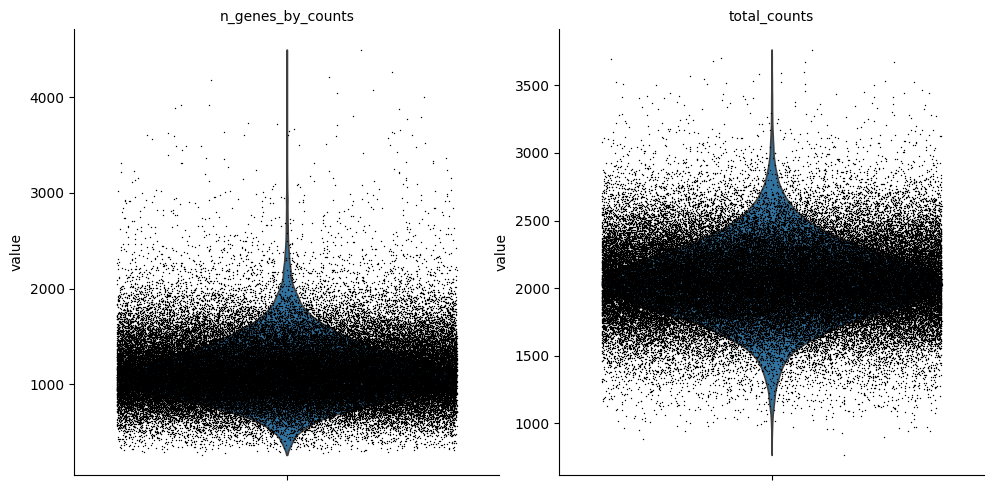

In [82]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

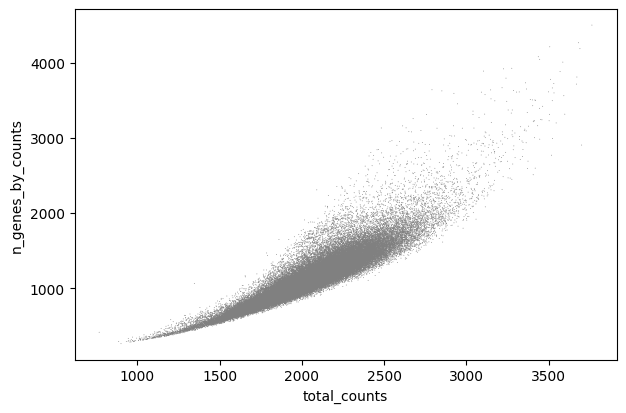

In [11]:
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [15]:
# Normalize total counts per cell : to mitigate the batch effects
sc.pp.normalize_total(adata, target_sum=1e4)

In [16]:
# Logarithmize the data
sc.pp.log1p(adata)

In [17]:
# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000) 

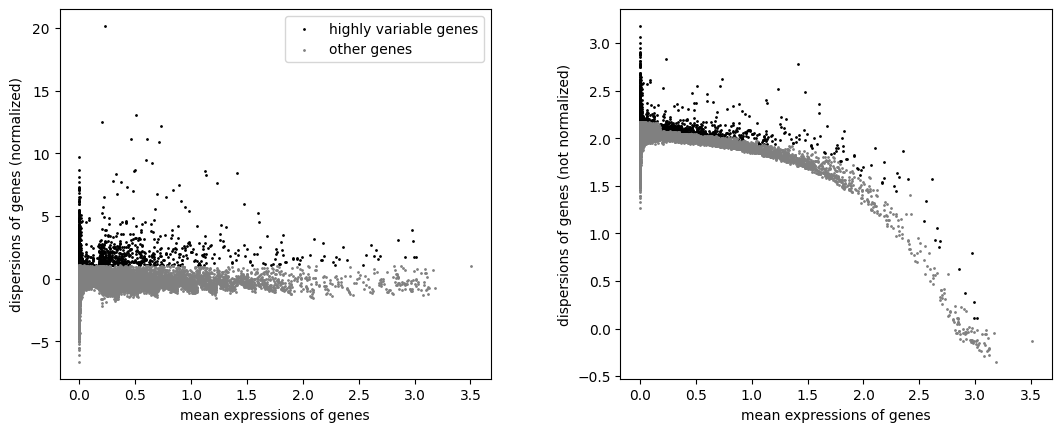

In [18]:
sc.pl.highly_variable_genes(adata)

In [19]:
adata = adata[:, adata.var.highly_variable]

In [20]:
# Scale the data
sc.pp.scale(adata, max_value=10)
    

/opt/conda/envs/multi-llm/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [21]:
adata

AnnData object with n_obs × n_vars = 76567 × 2000
    obs: 'mapped_reference_assembly', 'mapped_reference_annotation', 'alignment_software', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'donor_menopausal_status', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_derivation_process', 'sample_source', 'donor_BMI_at_collection', 'suspension_depleted_cell_types', 'suspension_derivation_process', 'suspension_dissociation_reagent', 'suspension_dissociation_time', 'suspension_percent_cell_viability', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'sequencing_platform', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'disease_ontology_term_id', 'sex_ontology_term_id', 'n_count_rna', 'n_feature_rna', 'percent_mito', 'percent_rb', 'tissue_location', 'bmi_group', 'procedure_group', 'age_

## Latent single-cell representation

Single-cell represenation is an important part of any single-cell analysis. There are many approaches, from simple PCA to batch-correcting algos on top of PCA (e.g.,[Harmony](https://github.com/lilab-bcb/harmony-pytorch)) to VAEs (e.g., [scVI](https://scvi-tools.org/)) to even much more recent Transformer-based approaches (e.g,. [Geneformer](https://huggingface.co/ctheodoris/Geneformer)). 

In this exercise you will build an autoencoder (not a VAE) to represent the cells. 
Challenges we'd like you to address: how can you get rid of the batch effect from the technology("assay" column)? can you use the cell_type as signal? 
Think about the right loss function / functions, network structure.
Steps:
1. Clean up the data
2. Choose highly variable genes (don't take more than 2,000)
3. Train you network
4. Evaluate the network
5. Compare to PCA

This isn't easy, your network should converge but it's totally fine if it doesn't beat PCA.
How would you improve it if you had 3 months?|

### Prepare dataloader

In [22]:
# Prepare labels
batch_encoder = LabelEncoder()
cell_type_encoder = LabelEncoder()

batch_labels = batch_encoder.fit_transform(adata.obs['assay'])
cell_type_labels = cell_type_encoder.fit_transform(adata.obs['cell_type'])

In [23]:
# Convert to PyTorch tensors
X = torch.FloatTensor(adata.X)
batch_labels = torch.LongTensor(batch_labels)
cell_type_labels = torch.LongTensor(cell_type_labels)

In [24]:
# Create train/val split
X_train, X_val, batch_train, batch_val, cell_type_train, cell_type_val = train_test_split(
    X, batch_labels, cell_type_labels, test_size=0.2, random_state=42
)

# Create data loaders
train_dataset = TensorDataset(X_train, batch_train, cell_type_train)
val_dataset = TensorDataset(X_val, batch_val, cell_type_val)


In [25]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

### AutoEncoder with weighted loss

In [26]:
# Normalize variance weights (optional, but often useful)
variance_weights = variance_abundance / variance_abundance.max()

# Convert to PyTorch tensor
variance_weights = torch.tensor(variance_weights.values, dtype=torch.float32)

In [27]:
variance_weights

tensor([3.9392e-04, 1.0000e+00, 8.7341e-03, 7.1775e-02, 3.7190e-01, 2.6485e-03,
        7.7811e-02, 6.7551e-02, 3.4978e-02, 1.8299e-01, 4.3790e-02, 9.5746e-01,
        1.2143e-01])

In [28]:
class Autoencoder_Weighted(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super().__init__()
        # Encoder architecture
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        # Decoder architecture
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

def train_autoencoder_weighted(model, train_loader, val_loader, variance_weights, num_epochs=100):
    device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
    print('Device in use:', device)
    model = model.to(device)

    variance_weights = variance_weights.to(device)
    
    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    # Loss function
    reconstruction_criterion = nn.MSELoss(reduction='none')
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    train_loss_acc, val_loss_acc = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, _, cell_type_labels) in enumerate(train_loader):
            data = data.to(device)
            cell_type_labels = cell_type_labels.to(device)
            # Forward pass
            reconstructed, _ = model(data)
            # Calculate weighted reconstruction loss
            recon_loss = reconstruction_criterion(reconstructed, data)
            weighted_recon_loss = (recon_loss.mean(dim=1) * variance_weights[cell_type_labels]).mean()
            # Backward pass
            optimizer.zero_grad()
            weighted_recon_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += weighted_recon_loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _, cell_type_labels in val_loader:
                data = data.to(device)
                cell_type_labels = cell_type_labels.to(device)
                reconstructed, _ = model(data)
                recon_loss = reconstruction_criterion(reconstructed, data)
                weighted_recon_loss = (recon_loss.mean(dim=1) * variance_weights[cell_type_labels]).mean()
                val_loss += weighted_recon_loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        train_loss_acc.append(train_loss)
        val_loss_acc.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    return train_loss_acc, val_loss_acc

In [29]:
# Initialize model
ae_weighted = Autoencoder_Weighted(input_dim=adata.n_vars, latent_dim=32)

In [30]:
# Train the ae_weighted
t_losses, v_losses = train_autoencoder_weighted(ae_weighted, train_loader, val_loader, variance_weights, num_epochs=30)

Device in use: cuda:3
Epoch 0, Train Loss: 0.0605, Val Loss: 0.0575
Epoch 1, Train Loss: 0.0577, Val Loss: 0.0567
Epoch 2, Train Loss: 0.0564, Val Loss: 0.0549
Epoch 3, Train Loss: 0.0555, Val Loss: 0.0543
Epoch 4, Train Loss: 0.0547, Val Loss: 0.0538
Epoch 5, Train Loss: 0.0541, Val Loss: 0.0531
Epoch 6, Train Loss: 0.0535, Val Loss: 0.0527
Epoch 7, Train Loss: 0.0530, Val Loss: 0.0523
Epoch 8, Train Loss: 0.0525, Val Loss: 0.0520
Epoch 9, Train Loss: 0.0520, Val Loss: 0.0516
Epoch 10, Train Loss: 0.0517, Val Loss: 0.0514
Epoch 11, Train Loss: 0.0513, Val Loss: 0.0513
Epoch 12, Train Loss: 0.0510, Val Loss: 0.0511
Epoch 13, Train Loss: 0.0507, Val Loss: 0.0510
Epoch 14, Train Loss: 0.0504, Val Loss: 0.0508
Epoch 15, Train Loss: 0.0502, Val Loss: 0.0507
Epoch 16, Train Loss: 0.0499, Val Loss: 0.0506
Epoch 17, Train Loss: 0.0497, Val Loss: 0.0505
Epoch 18, Train Loss: 0.0495, Val Loss: 0.0504
Epoch 19, Train Loss: 0.0493, Val Loss: 0.0503
Epoch 20, Train Loss: 0.0491, Val Loss: 0.0502
E

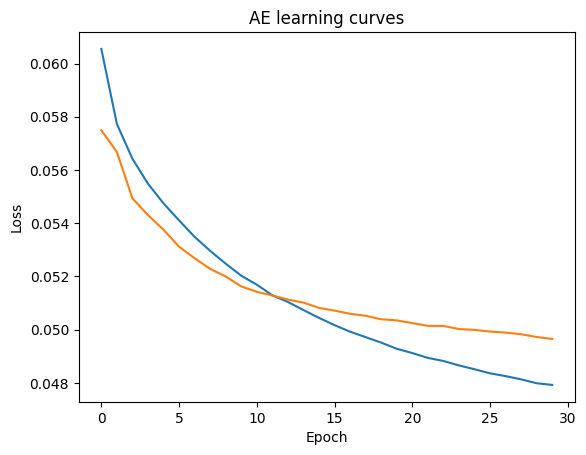

In [31]:
plt.title('AE learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(t_losses)
plt.plot(v_losses)

**Training can be continued**

## Evaluation and Comparison with PCA

In [32]:
def get_latent_representations(model, adata, X):
    # Compare with PCA
    pca = PCA(n_components=32)
    pca_result = pca.fit_transform(adata.X)
    
    # Get autoencoder latent representation
    model.eval()
    with torch.no_grad():
        _, ae_latent = model(X.to('cuda:3'))
        ae_latent = ae_latent.cpu().numpy()

    return pca_result, ae_latent

In [33]:
pca_result, ae_latent = get_latent_representations(model=ae_weighted, adata=adata, X=X)

## Predicting disease state from your latent representation.

Now that you have a decent latent representation, define
1) Train/test split based on `donor_id`
2) Classificaton task and performance metric based on `disease`
3) Set of classifiers you want to try for this task (logistic regression and XGBoost are good lightweight places to start, but you're welcome to use and explore others as well).
4) Compare the PCA and AE latent representations, which is better for the classification task?

In this section, train your classifiers and report and discuss your performance metrics. A few questions to guide your discussion:
- How well do you do compared to a random/dummy classifier?
- How much overfitting are your seeing? How much did regularization help?
- What else would you try if you had (or wanted to spend) more time on this assignment?

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm


def prepare_train_test_split(X, anndata, test_size=0.2, random_state=42):
    """
    Split data based on donor_id to prevent data leakage
    """
    # Get the features and labels
    print("Training disease classifier...")
    disease_labels = LabelEncoder().fit_transform(anndata.obs['reported_diseases'])
    # Split data by donor_id
    unique_donors = np.unique(anndata.obs['donor_id'])
    np.random.seed(random_state)
    train_donors = np.random.choice(unique_donors, size=int(0.8 * len(unique_donors)), replace=False)
    train_mask = anndata.obs['donor_id'].isin(train_donors)
    X_train = X[train_mask]
    X_test = X[~train_mask]
    y_train = disease_labels[train_mask]
    y_test = disease_labels[~train_mask]

    return X_train, X_test, y_train, y_test

def evaluate_classifier(clf, X_train, X_test, y_train, y_test, name):
    """
    Train and evaluate a classifier with basic metrics
    """
    # Train the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    # Calculate ROC AUC if the classifier has predict_proba
    if hasattr(clf, "predict_proba"):
        train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
        test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    else:
        train_auc = None
        test_auc = None
    
    # Calculate distinct metrics for training data
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Calculate distinct metrics for test data
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    return {
        'train': {
            'auc': train_auc,
            'precision': train_precision,
            'recall': train_recall,
            'f1_score': train_f1,
            'accuracy': train_accuracy
        },
        'test': {
            'auc': test_auc,
            'precision': test_precision,
            'recall': test_recall,
            'f1_score': test_f1,
            'accuracy': test_accuracy
        }
    }

def compare_representations(pca_results, ae_latent, adata):
    """
    Compare PCA and AE representations using multiple classifiers
    """
    results = {}
    # Prepare splits for both representations
    ae_splits = prepare_train_test_split(X=ae_latent, anndata=adata)
    pca_splits = prepare_train_test_split(X=pca_results, anndata=adata)
    
    # Define classifiers
    classifiers = {
        'dummy': DummyClassifier(strategy='stratified'),
        'logreg': LogisticRegression(max_iter=1000, random_state=42),
        'xgboost': xgb.XGBClassifier(random_state=42)
    }
    
    # Test each classifier on both representations
    for repr_name, splits in [('PCA', pca_splits), ('AE', ae_splits)]:
        X_train, X_test, y_train, y_test = splits
        results[repr_name] = {}
        for clf_name, clf in classifiers.items():
            results[repr_name][clf_name] = evaluate_classifier(
                clf, X_train, X_test, y_train, y_test,
                f"{repr_name} - {clf_name}"
            )
    return results


# Here is function for grid search
def compare_representations_with_gridsearch(pca_results, ae_latent, adata):
    """
    Compare PCA and AE representations using multiple classifiers
    """
    results = {}
    # Prepare splits for both representations
    ae_splits = prepare_train_test_split(X=ae_latent, anndata=adata)
    pca_splits = prepare_train_test_split(X=pca_results, anndata=adata)
    
    # Define classifiers and their parameter grids for grid search
    classifiers = {
        'dummy': DummyClassifier(strategy='stratified'),
        'logreg': LogisticRegression(max_iter=1000, random_state=42),
        'xgboost': xgb.XGBClassifier(random_state=42, device='cuda:3')
    }
    
    param_grids = {
        # 'logreg': {
        #     'C': [0.01, 0.1, 1, 10, 100],
        #     'penalty': ['l1', 'l2']
        # },
        'xgboost': {
            'max_depth': [3, 5], 
            'min_child_weight': [1, 2], 
            'subsample': [0.6, 0.8], 
            'learning_rate': [0.01, 0.1],
            'n_estimators': [100, 200] 
        }
    }
    
    # Test each classifier on both representations
    for repr_name, splits in [('PCA', pca_splits), ('AE', ae_splits)]:
        X_train, X_test, y_train, y_test = splits
        results[repr_name] = {}
        for clf_name, clf in classifiers.items():
            if clf_name in param_grids:
                grid_search = GridSearchCV(clf, param_grids[clf_name], cv=3, scoring='roc_auc', verbose=1)
                grid_search.fit(X_train, y_train)
                best_clf = grid_search.best_estimator_
                print(f"Best parameters for {clf_name} on {repr_name}: {grid_search.best_params_}")
                results[repr_name][clf_name] = evaluate_classifier(
                    best_clf, X_train, X_test, y_train, y_test,
                    f"{repr_name} - {clf_name}"
                )
            else:
                results[repr_name][clf_name] = evaluate_classifier(
                    clf, X_train, X_test, y_train, y_test,
                    f"{repr_name} - {clf_name}"
                )
    return results

In [35]:
results = compare_representations_with_gridsearch(pca_result, ae_latent, adata)

Training disease classifier...
Training disease classifier...
Fitting 3 folds for each of 32 candidates, totalling 96 fits


/opt/conda/envs/multi-llm/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [19:48:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:3, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Best parameters for xgboost on PCA: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 0.6}
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters for xgboost on AE: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 0.6}


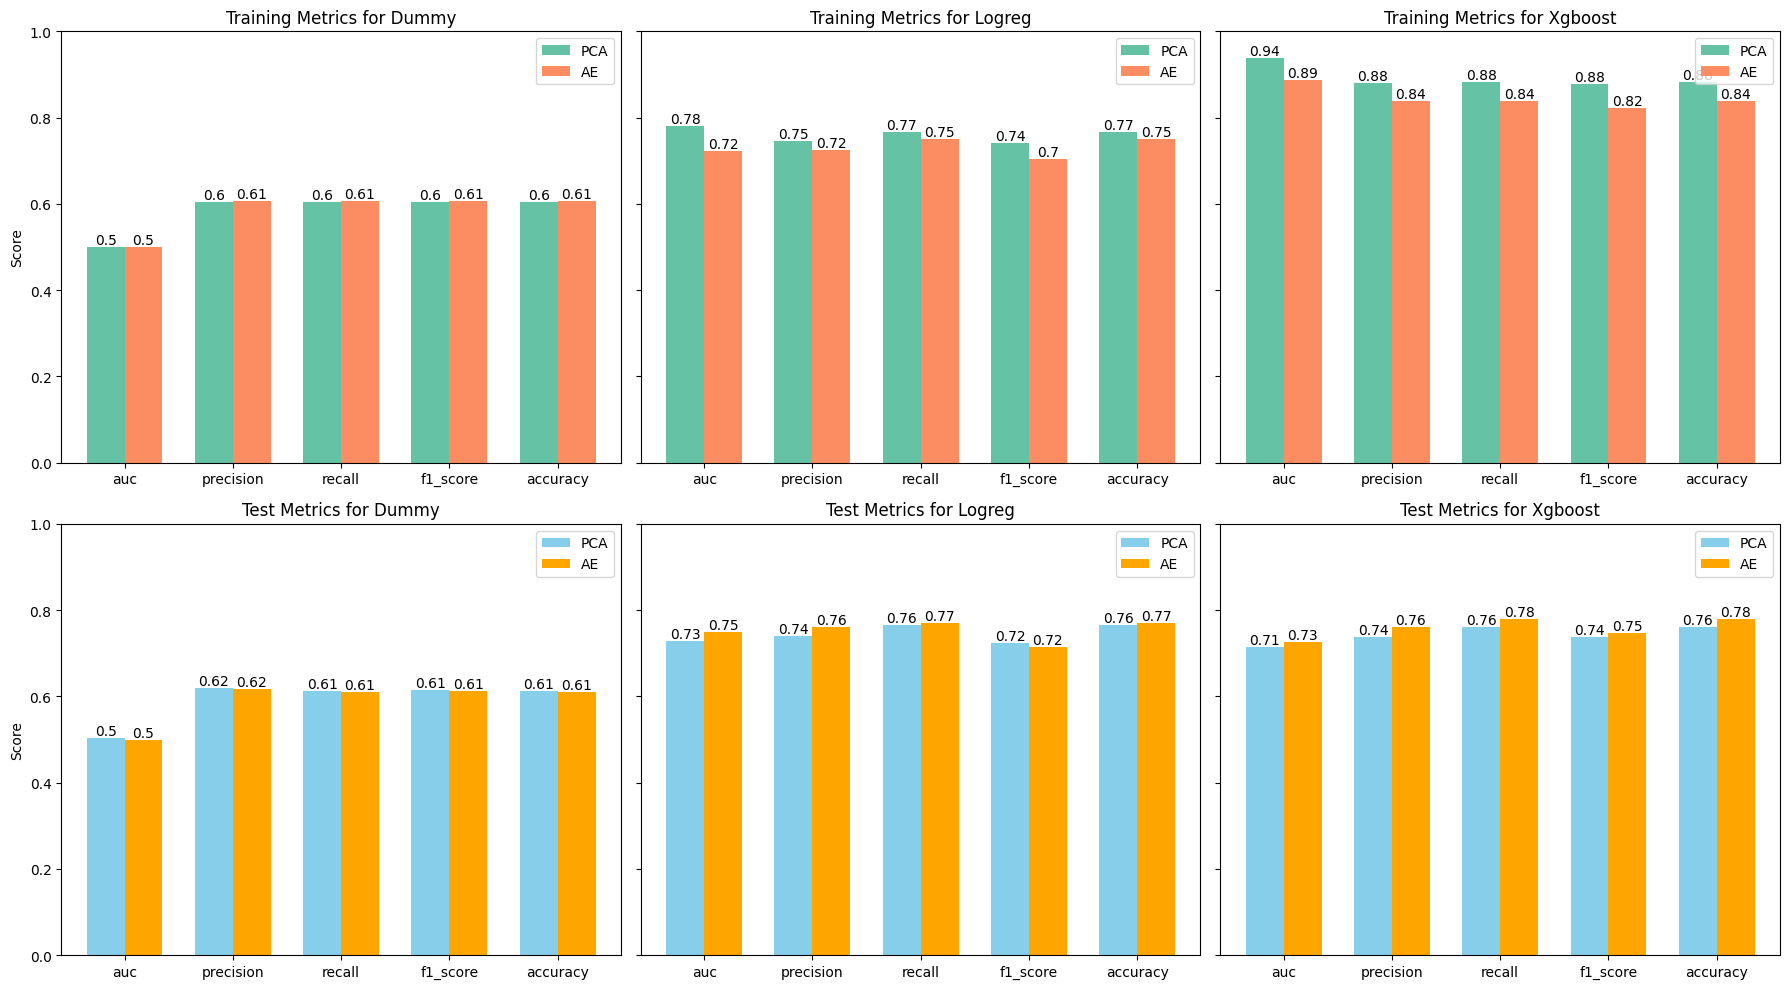

In [36]:
metrics = ['auc', 'precision', 'recall', 'f1_score', 'accuracy']
models = ['dummy', 'logreg', 'xgboost']

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

# Iterate over each model to create a plot
for i, model in enumerate(models):
    # Extract PCA and AE values for training metrics
    pca_train_values = [results['PCA'][model]['train'][metric] for metric in metrics]
    ae_train_values = [results['AE'][model]['train'][metric] for metric in metrics]

    # Extract PCA and AE values for test metrics
    pca_test_values = [results['PCA'][model]['test'][metric] for metric in metrics]
    ae_test_values = [results['AE'][model]['test'][metric] for metric in metrics]

    bar_width = 0.35
    index = np.arange(len(metrics))

    # Create bars for training metrics
    pca_train_bars = axes[0, i].bar(index, pca_train_values, bar_width, label='PCA', color='#66c2a5')
    ae_train_bars = axes[0, i].bar(index + bar_width, ae_train_values, bar_width, label='AE', color='#fc8d62')

    # Create bars for test metrics
    pca_test_bars = axes[1, i].bar(index, pca_test_values, bar_width, label='PCA', color='skyblue')
    ae_test_bars = axes[1, i].bar(index + bar_width, ae_test_values, bar_width, label='AE', color='orange')

    # Adding labels and title for training metrics
    axes[0, i].set_title(f'Training Metrics for {model.capitalize()}')
    axes[0, i].set_xticks(index + bar_width / 2)
    axes[0, i].set_xticklabels(metrics)
    axes[0, i].set_ylim(0, 1)

    # Adding labels and title for test metrics
    axes[1, i].set_title(f'Test Metrics for {model.capitalize()}')
    axes[1, i].set_xticks(index + bar_width / 2)
    axes[1, i].set_xticklabels(metrics)
    axes[1, i].set_ylim(0, 1)

    # Add values on top of the bars for training metrics
    for bar in pca_train_bars + ae_train_bars:
        yval = bar.get_height()
        axes[0, i].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

    # Add values on top of the bars for test metrics
    for bar in pca_test_bars + ae_test_bars:
        yval = bar.get_height()
        axes[1, i].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

    if i == 0:
        axes[0, i].set_ylabel('Score')
        axes[1, i].set_ylabel('Score')

    axes[0, i].legend()
    axes[1, i].legend()

plt.tight_layout()
plt.show()

Xgboost overfitted on training data but grid-search helped to reduce this overfitting (results without overfitting are bellow).

Conclusion on classification metrics: AE latent space is slightly better than PCA. 


### Here are the metrics without grid search for xgboost, the model performs a little worse on test and is more overfitted

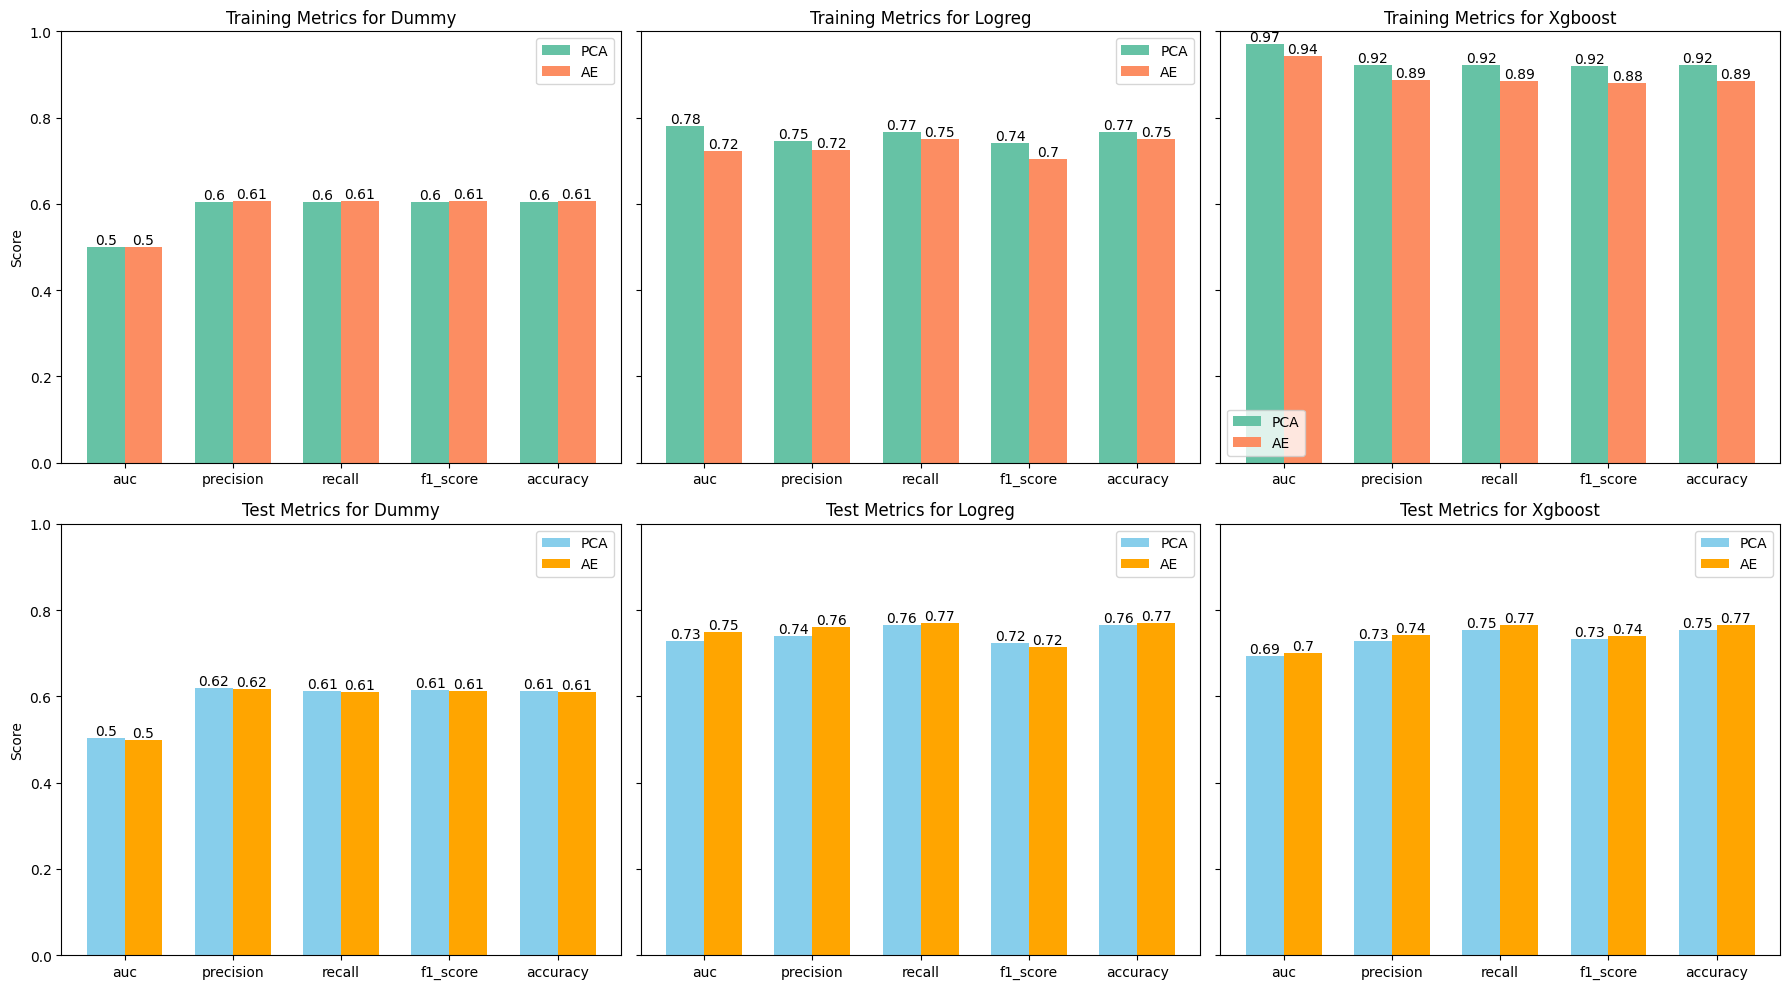

In [124]:
metrics = ['auc', 'precision', 'recall', 'f1_score', 'accuracy']
models = ['dummy', 'logreg', 'xgboost']

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

# Iterate over each model to create a plot
for i, model in enumerate(models):
    # Extract PCA and AE values for training metrics
    pca_train_values = [results['PCA'][model]['train'][metric] for metric in metrics]
    ae_train_values = [results['AE'][model]['train'][metric] for metric in metrics]

    # Extract PCA and AE values for test metrics
    pca_test_values = [results['PCA'][model]['test'][metric] for metric in metrics]
    ae_test_values = [results['AE'][model]['test'][metric] for metric in metrics]

    bar_width = 0.35
    index = np.arange(len(metrics))

    # Create bars for training metrics
    pca_train_bars = axes[0, i].bar(index, pca_train_values, bar_width, label='PCA', color='#66c2a5')
    ae_train_bars = axes[0, i].bar(index + bar_width, ae_train_values, bar_width, label='AE', color='#fc8d62')

    # Create bars for test metrics
    pca_test_bars = axes[1, i].bar(index, pca_test_values, bar_width, label='PCA', color='skyblue')
    ae_test_bars = axes[1, i].bar(index + bar_width, ae_test_values, bar_width, label='AE', color='orange')

    # Adding labels and title for training metrics
    axes[0, i].set_title(f'Training Metrics for {model.capitalize()}')
    axes[0, i].set_xticks(index + bar_width / 2)
    axes[0, i].set_xticklabels(metrics)
    axes[0, i].set_ylim(0, 1)

    # Adding labels and title for test metrics
    axes[1, i].set_title(f'Test Metrics for {model.capitalize()}')
    axes[1, i].set_xticks(index + bar_width / 2)
    axes[1, i].set_xticklabels(metrics)
    axes[1, i].set_ylim(0, 1)

    # Add values on top of the bars for training metrics
    for bar in pca_train_bars + ae_train_bars:
        yval = bar.get_height()
        axes[0, i].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

    # Add values on top of the bars for test metrics
    for bar in pca_test_bars + ae_test_bars:
        yval = bar.get_height()
        axes[1, i].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

    if i == 0:
        axes[0, i].set_ylabel('Score')
        axes[1, i].set_ylabel('Score')

    axes[0, i].legend()
    axes[1, i].legend()

plt.tight_layout()
plt.show()

## Next Steps

1. **Implement Adversarial Component in Autoencoder (AE) Loss:**
   - Define the total loss function as:
    ```total_loss = recon_loss - 0.1 * batch_loss + 0.5 * cell_type_loss```
   - Create two classifiers: for `batch_loss` and for `cell_type_loss`
   - `development_stage` feature could be added to loss too.

2. **Experiment with Different Autoencoder Architectures:**
   - Explore variations in:
     - Number of layers
     - Number of neurons
     - Activation functions
   - Adjust training parameters and apply regularization techniques.

3. **Apply Feature Selection Methods:**

4. **Conduct Comprehensive Grid Search for hyperparameter tuning on XGBoost and Logistic Regression**


5. **Perform Z-Score Batch Correction Using `sample_id`:**
   - Implement the following code snippet to standardize batch data:
     ```python
     # Get batch mask
     batch_mask = adata.obs['sample_id'] == x
     # Get batch data
     batch_data = X[batch_mask]
     batch_means = np.mean(batch_data, axis=0)
     batch_stds = np.std(batch_data, axis=0)
     # Avoid division by zero
     batch_stds[batch_stds == 0] = 1.0
     # Standardize batch data
     X_corrected[batch_mask] = (batch_data - batch_means) / batch_stds
     ```
